# Evaluation of trained models

In [1]:
from prettytable import PrettyTable
from typing import Optional, Dict, Union, Literal
import torch
import pytorch_lightning as pl
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

from HECKTOR_Dataset import Mode, Modality
from HECKTOR_DataModule import HECKTOR_DataModule
from HECKTOR_Model import HECKTOR_Model, PCA_HECKTOR_Model

In [3]:
# Testing hyperparameters:
DATA_PATH = "/home/dzban112/HECKTOR/Data/"
CHECKPOINTS_PATH="/home/dzban112/HECKTOR/ckpt/"
BATCH_SIZE = 16
NUM_WORKERS = 4
SELECTED_TRAIN_TRANSFORMS = ["elastic", "histogram"] # Test images will be also cropped to specified ROI. 

## Evaluation

In [5]:
def model_evaluation(model_name:str, version:Optional[str]=None):
    """
    Evaluates Hecktor model on the test set.
    """
    res={}
    def _setup(fold:Union[int, Literal["all"]]=1):
        # DataModule setup:
        dm = HECKTOR_DataModule(
            fold=fold,
            data_path=DATA_PATH,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            selected_train_transforms=SELECTED_TRAIN_TRANSFORMS,
            modality=MODALITY
        )
        
        if version is None:
            ckpt_path = CHECKPOINTS_PATH+model_name+f"_{fold}"+".ckpt"
        else:
            ckpt_path = CHECKPOINTS_PATH+model_name+f"_{fold}"+f"-{version}"+".ckpt"
        # Model setup:
        model = HECKTOR_Model.load_from_checkpoint(ckpt_path)
        # Trainer setup:
        torch.set_float32_matmul_precision('medium')
        trainer = pl.Trainer(accelerator="gpu", devices=1, precision=32, logger=False)
        
        return dm, model, trainer

    # Evaluating models trained on 5CV training sets:
    for fold in range(1, 6):
        dm, model, trainer = _setup(fold=fold)
        model.eval()
        res[f"val_fold_{fold}"] = trainer.validate(model, dm)
        res[f"test_fold_{fold}"] = trainer.test(model, dm)

    if version == None:
        # Evaluating model trained on the whole training set:
        fold="all"
        dm, model, trainer = _setup(fold=fold)
        model.eval()
        res["test_all"] = trainer.test(model, dm)
        
    return res


def compute_results(raw_results:Dict[str, list]):
    val_c_index = []
    test_c_index = []
    test_loss = []
    folds = []

    for fold in range(1,6):
        curr_val_c_index = round(raw_results[f"val_fold_{fold}"][0]["val_C-index"],3)
        curr_test_c_index = round(raw_results[f"test_fold_{fold}"][0]["test_C-index"],3)
        curr_test_loss = round(raw_results[f"test_fold_{fold}"][0]["test_loss"],3)
        val_c_index.append(curr_val_c_index)
        test_c_index.append(curr_test_c_index)
        test_loss.append(curr_test_loss)
        folds.append(f"Fold {fold}")

    # Results of model trained on the whole train set:
    if "test_all" in raw_results.keys():
        val_c_index.append("NA")
        test_c_index.append(round(raw_results["test_all"][0]["test_C-index"],3))
        test_loss.append(round(raw_results["test_all"][0]["test_loss"],3))
        folds.append("All train set")

    df = pd.DataFrame({"Fold": folds, "Test C-index": test_c_index, "Val C-index": val_c_index, "Test loss": test_loss})
    
    table = PrettyTable()
    table.field_names = df.columns.tolist()

    for row in df.itertuples(index=False):
        table.add_row(row)

    for field in df.columns:
        table.align[field] = 'l'
    
    return table

### DINO_ViTs8 - only CT

##### Version 0

In [ ]:
# version 0
MODALITY = Modality.CT
res = model_evaluation("dino_vits8_1")

In [7]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.531,0.544,2.531
Fold 2,0.569,0.667,2.529
Fold 3,0.505,0.597,2.559
Fold 4,0.547,0.58,2.526
Fold 5,0.533,0.552,2.536
All train set,0.554,NA,2.535


##### Version 1

In [ ]:
# version 1
MODALITY = Modality.CT
res = model_evaluation("dino_vits8_1", "v1")

In [11]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.571,0.521,2.542
Fold 2,0.57,0.665,2.529
Fold 3,0.468,0.589,2.527
Fold 4,0.548,0.579,2.526
Fold 5,0.543,0.555,2.535


##### Version 2

In [ ]:
# version 2
MODALITY = Modality.CT
res = model_evaluation("dino_vits8_1", "v2")

In [13]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.538,0.529,2.532
Fold 2,0.57,0.665,2.529
Fold 3,0.536,0.571,2.528
Fold 4,0.548,0.579,2.526
Fold 5,0.555,0.555,2.532


### DINO_ViTs8 - Both CT and PET

##### Version 0

In [ ]:
# version 0
MODALITY = Modality.BOTH
res = model_evaluation("dino_vits8_3")

In [15]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.577,0.658,2.536
Fold 2,0.549,0.509,2.527
Fold 3,0.571,0.637,2.612
Fold 4,0.547,0.563,2.559
Fold 5,0.582,0.657,2.528
All train set,0.582,NA,2.57


##### Version 1

In [ ]:
# version 1
MODALITY = Modality.BOTH
res = model_evaluation("dino_vits8_3", "v1")

In [17]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.576,0.686,2.544
Fold 2,0.566,0.606,2.542
Fold 3,0.567,0.632,2.608
Fold 4,0.588,0.625,2.52
Fold 5,0.586,0.648,2.553


##### Version 2

In [ ]:
# version 2
MODALITY = Modality.BOTH
res = model_evaluation("dino_vits8_3", "v2")

In [19]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.573,0.675,2.541
Fold 2,0.566,0.578,2.538
Fold 3,0.564,0.647,2.542
Fold 4,0.574,0.584,2.529
Fold 5,0.587,0.717,2.571


### DINO_ViTs8 - CT merged with PET

##### Version 0

In [ ]:
# version 0
MODALITY = Modality.MERGED
res = model_evaluation("dino_vits8_2")

In [21]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.571,0.659,2.527
Fold 2,0.564,0.597,2.543
Fold 3,0.557,0.66,2.575
Fold 4,0.592,0.613,2.521
Fold 5,0.558,0.678,2.585
All train set,0.557,NA,2.536


##### Version 1

In [ ]:
# version 1
MODALITY = Modality.MERGED
res = model_evaluation("dino_vits8_2", "v1")

In [23]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.564,0.691,2.538
Fold 2,0.537,0.593,2.547
Fold 3,0.555,0.653,2.591
Fold 4,0.594,0.632,2.551
Fold 5,0.558,0.678,2.585


##### Version 2

In [ ]:
# version 2
MODALITY = Modality.MERGED
res = model_evaluation("dino_vits8_2", "v2")

In [25]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.57,0.677,2.532
Fold 2,0.561,0.604,2.551
Fold 3,0.558,0.656,2.582
Fold 4,0.601,0.595,2.504
Fold 5,0.558,0.679,2.586


### DINO_ViTb8 - only CT

##### Version 0

In [ ]:
# version 0
MODALITY = Modality.CT
res = model_evaluation("dino_vitb8_4")

In [7]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.453,0.541,2.783
Fold 2,0.513,0.58,2.721
Fold 3,0.51,0.609,2.531
Fold 4,0.542,0.585,2.535
Fold 5,0.563,0.56,2.528
All train set,0.559,NA,2.528


##### Version 1

In [ ]:
MODALITY = Modality.CT
res = model_evaluation("dino_vitb8_4", "v1")

In [9]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.52,0.553,2.63
Fold 2,0.573,0.676,2.529
Fold 3,0.492,0.613,2.532
Fold 4,0.553,0.549,2.527
Fold 5,0.559,0.58,2.533


##### Version 2

In [ ]:
# version 2
MODALITY = Modality.CT
res = model_evaluation("dino_vitb8_4", "v2")

In [11]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.585,0.558,2.536
Fold 2,0.55,0.636,2.531
Fold 3,0.508,0.471,2.536
Fold 4,0.542,0.585,2.535
Fold 5,0.586,0.521,2.535


### DINO_ViTb8 - Both CT and PET

##### Version 0

In [ ]:
MODALITY = Modality.BOTH
res = model_evaluation("dino_vitb8_6")

In [13]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.589,0.66,2.536
Fold 2,0.494,0.612,2.82
Fold 3,0.573,0.642,2.54
Fold 4,0.563,0.577,2.592
Fold 5,0.577,0.671,2.539
All train set,0.557,NA,2.623


##### Version 1

In [ ]:
MODALITY = Modality.BOTH
res = model_evaluation("dino_vitb8_6", "v1")

In [15]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.589,0.659,2.536
Fold 2,0.525,0.599,2.846
Fold 3,0.575,0.644,2.547
Fold 4,0.564,0.575,2.56
Fold 5,0.552,0.638,2.676


##### Version 2

In [16]:
MODALITY = Modality.BOTH
res = model_evaluation("dino_vitb8_6", "v2")

/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index           0.659771740436554
        val_loss            2.2106716632843018
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5889586210250854
        test_loss            2.536454677581787
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6598101258277893
        val_loss            2.4495646953582764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5897887945175171
        test_loss            2.523125410079956
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6788321137428284
        val_loss            2.4583115577697754
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:29<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5695532560348511
        test_loss           2.6837105751037598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.5767235159873962
        val_loss             2.25651216506958
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5628599524497986
        test_loss           2.5946123600006104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6709429025650024
        val_loss             2.422536611557007
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5766097903251648
        test_loss           2.5387747287750244
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [17]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.589,0.66,2.536
Fold 2,0.59,0.66,2.523
Fold 3,0.57,0.679,2.684
Fold 4,0.563,0.577,2.595
Fold 5,0.577,0.671,2.539


### DINO_ViTb8 - CT merged with PET

##### Version 0

In [18]:
MODALITY = Modality.MERGED
res = model_evaluation("dino_vitb8_5")

/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6654778718948364
        val_loss              2.2504723072052
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5626524090766907
        test_loss           2.5393335819244385
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.5854430198669434
        val_loss            2.4706125259399414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5620297789573669
        test_loss           2.5356035232543945
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6602521538734436
        val_loss             2.428633451461792
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5553883910179138
        test_loss           2.5817129611968994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6212009191513062
        val_loss            2.2176411151885986
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index           0.561822235584259
        test_loss            2.541736602783203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6350224614143372
        val_loss             2.413693904876709
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5620297789573669
        test_loss           2.6111481189727783
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5567374229431152
        test_loss           2.6062557697296143
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [19]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.563,0.665,2.539
Fold 2,0.562,0.585,2.536
Fold 3,0.555,0.66,2.582
Fold 4,0.562,0.621,2.542
Fold 5,0.562,0.635,2.611
All train set,0.557,NA,2.606


##### Version 1

In [20]:
MODALITY = Modality.MERGED
res = model_evaluation("dino_vitb8_5", "v1")

/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index           0.687589168548584
        val_loss             2.250404119491577
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5597468018531799
        test_loss           2.5396621227264404
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.5846518874168396
        val_loss            2.4627861976623535
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:31<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5487469434738159
        test_loss           2.5357022285461426
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6702057123184204
        val_loss            2.4516987800598145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5595911145210266
        test_loss           2.5514321327209473
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:25<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.5789473652839661
        val_loss            2.1598310470581055
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:31<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5151247978210449
        test_loss            2.711453437805176
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index           0.645285427570343
        val_loss            2.3429667949676514
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5497328042984009
        test_loss            2.600771903991699
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [21]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.56,0.688,2.54
Fold 2,0.549,0.585,2.536
Fold 3,0.56,0.67,2.551
Fold 4,0.515,0.579,2.711
Fold 5,0.55,0.645,2.601


##### Version 2

In [22]:
MODALITY = Modality.MERGED
res = model_evaluation("dino_vitb8_5", "v2")

/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6818830370903015
        val_loss             2.222334861755371
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:29<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5552327036857605
        test_loss           2.5441339015960693
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.5886076092720032
        val_loss             2.445624589920044
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5374876856803894
        test_loss           2.6049444675445557
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6569343209266663
        val_loss            2.4547324180603027
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5565298795700073
        test_loss           2.5698351860046387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6041512489318848
        val_loss            2.2073278427124023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:30<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5581383109092712
        test_loss            2.570939064025879
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  0.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_C-index          0.6337395906448364
        val_loss            2.4187257289886475
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/lu/tetyda/home/dzban112/my_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /lu/tetyda/home/dzban112/my_env/lib/python3.10/site ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:31<00:00,  0.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_C-index          0.5592279434204102
        test_loss           2.6070096492767334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [23]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.555,0.682,2.544
Fold 2,0.537,0.589,2.605
Fold 3,0.557,0.657,2.57
Fold 4,0.558,0.604,2.571
Fold 5,0.559,0.634,2.607


## Incorporating PCA between Encoder and MLP Head.

Obtaining hidden states for a training set to fit on them PCA.

In [4]:
import torch
from typing import Optional, Union, Literal
from sklearn.decomposition import PCA
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

def fit_PCA(model_name: str,
            version: Optional[str] = None,
            n_components:Optional[int]=30,
            plot_variance_ratio:bool=False,
            save_PCA_factors:bool=False
           ):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    def _setup(fold: Union[int, Literal["all"]] = 1):
        # DataModule setup
        dm = HECKTOR_DataModule(
            fold=fold,
            data_path=DATA_PATH,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            selected_train_transforms=SELECTED_TRAIN_TRANSFORMS,
            modality=MODALITY
        )
        
        if version is None:
            ckpt_path = CHECKPOINTS_PATH + model_name + f"_{fold}" + ".ckpt"
        else:
            ckpt_path = CHECKPOINTS_PATH + model_name + f"_{fold}" + f"-{version}" + ".ckpt"
        
        # Model setup
        model = HECKTOR_Model.load_from_checkpoint(ckpt_path)
        model = model.to(device)
        return dm, model

    def _plot_variance_ratio(pca, fold):
        cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
        return cumulative_explained_variance

    res = {}
    all_cumulative_explained_variances = []
    
    for fold in range(1, 6):
        print(f"Fold: {fold}")
        dm, model = _setup(fold=fold)
        dm.setup()
        train_loader = dm.train_dataloader()
        res[f"fold_{fold}"] = []
        
        for batch in tqdm(iter(train_loader)):
            inputs = batch["crop"].to(device)
            with torch.no_grad():
                hs = model.forward(inputs, extract_hidden_states=True)
            res[f"fold_{fold}"].append(hs.cpu())

    if version == None:
        fold = "all"
        print(f"Fold: {fold}")
        dm, model = _setup(fold=fold)
        dm.setup()
        train_loader = dm.train_dataloader()
        res[f"fold_{fold}"] = []
        for batch in tqdm(iter(train_loader)):
            inputs = batch["crop"].to(device)
            with torch.no_grad():
                hs = model.forward(inputs, extract_hidden_states=True)
                res[f"fold_{fold}"].append(hs.cpu())
       
    print("Finalizing features extraction ...")
    for key in res.keys():
        res[key] = torch.cat(res[key], dim=0).numpy()
    print("Features extracted")      
    print("Fitting PCA ...")
    
    for fold, key in enumerate(res.keys(), start=1):
        pca = PCA(n_components=n_components)
        pca.fit(res[key])

        if plot_variance_ratio:
            cumulative_explained_variance = _plot_variance_ratio(pca, fold)
            all_cumulative_explained_variances.append((fold, cumulative_explained_variance))

        if save_PCA_factors:
            save_path = save_path = f"Data/train_data/PCA_factors/{model_name}_{version + '_' if version is not None else ''}{key}.pt"
            pca_components = torch.Tensor(pca.components_)
            pca_mean = torch.Tensor(pca.mean_)
            torch.save({"components": pca_components, "mean": pca_mean}, save_path)
    
    if plot_variance_ratio:
        plt.figure(figsize=(10, 5))
        for fold, cumulative_explained_variance in all_cumulative_explained_variances:
            plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', label=f'Fold {fold}')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Explained Variance as a Function of the Number of Components')
        plt.legend()
        plt.grid(True)
        plt.show()

    print("Done")

#### Exctracting features ViTs8 - CT

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.90it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.82it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.88it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.81it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.83it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.00it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


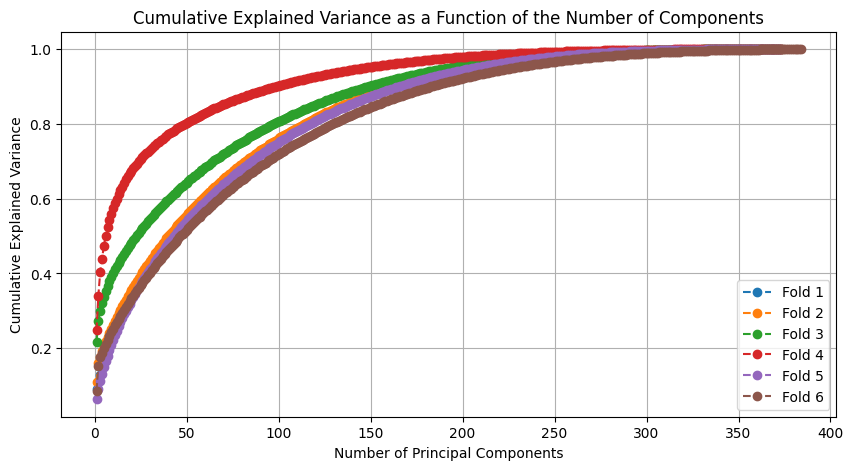

Done


In [7]:
MODALITY = Modality.CT
results = fit_PCA("dino_vits8_1", n_components=None, plot_variance_ratio=True)

##### Saving top n components

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.75it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.55it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.81it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.80it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.91it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


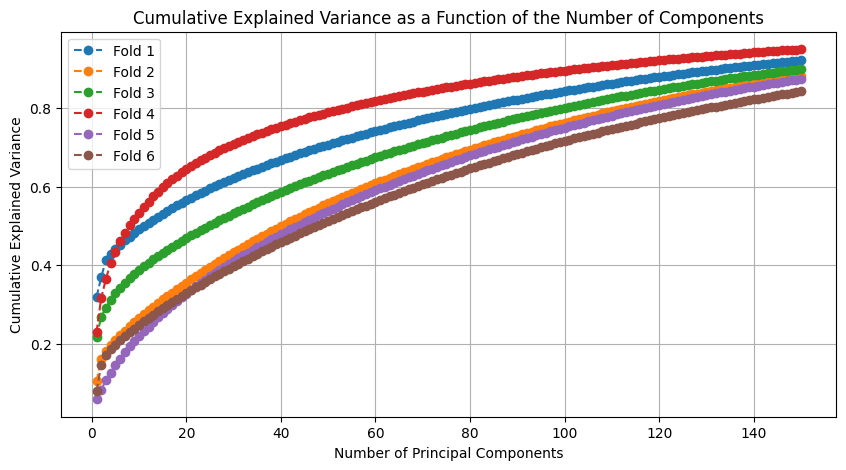

Done


In [8]:
MODALITY = Modality.CT
results = fit_PCA("dino_vits8_1", n_components=150, plot_variance_ratio=True, save_PCA_factors=True)

#### Exctracting features ViTs8 - BOTH CT and PET

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.19it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.11it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.08it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.11it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.12it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.06it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


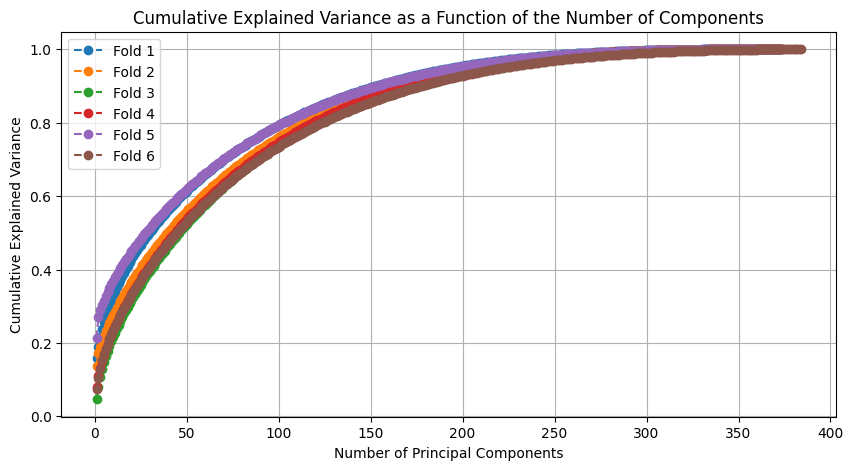

Done


In [9]:
MODALITY = Modality.BOTH
results = fit_PCA("dino_vits8_3", n_components=None, plot_variance_ratio=True)

##### Saving top n components

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.02it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.22it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.12it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.05it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.10it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.12it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


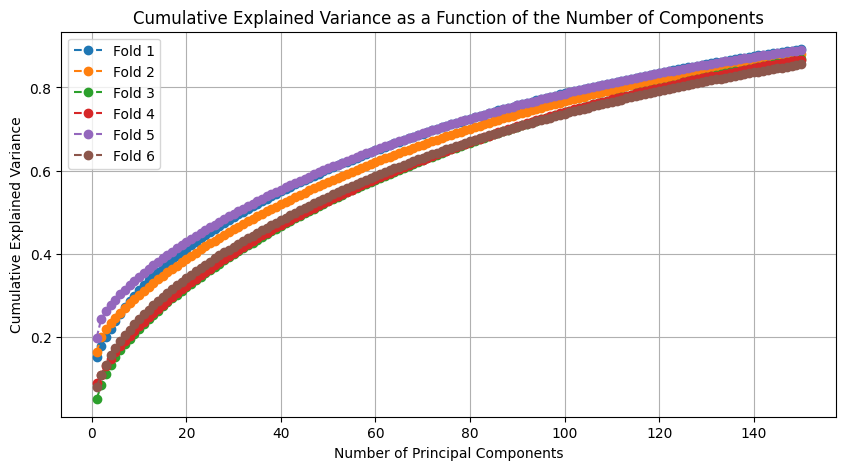

Done


In [10]:
MODALITY = Modality.BOTH
results = fit_PCA("dino_vits8_3", n_components=150, plot_variance_ratio=True, save_PCA_factors=True)

#### Exctracting features ViTs8 - MERGED CT and PET

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.09it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.15it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.07it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.19it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.09it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.01it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


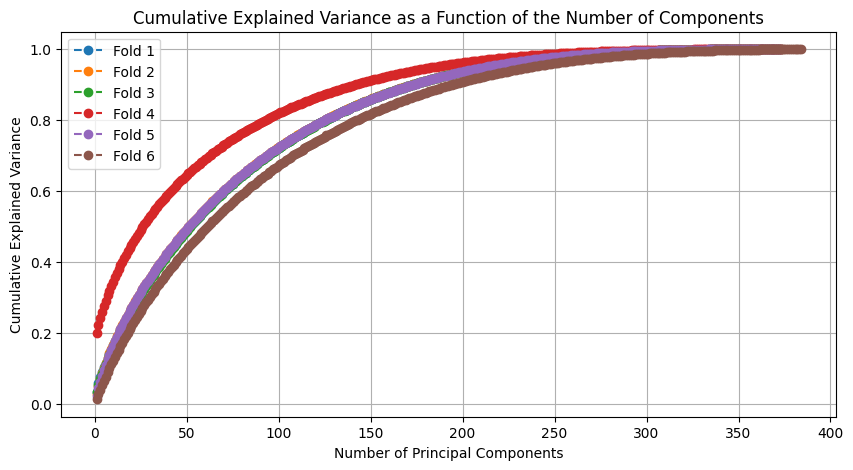

Done


In [11]:
MODALITY = Modality.MERGED
results = fit_PCA("dino_vits8_2", n_components=None, plot_variance_ratio=True)

##### Saving top n components

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.18it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.22it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.10it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.08it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.11it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.19it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


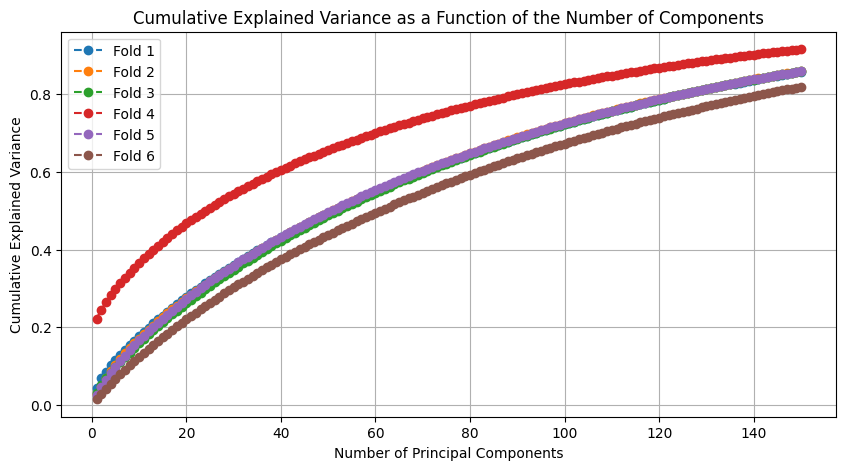

Done


In [12]:
MODALITY = Modality.MERGED
results = fit_PCA("dino_vits8_2", n_components=150, plot_variance_ratio=True, save_PCA_factors=True)

#### Exctracting features ViTb8 - CT

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:21<00:00,  1.14it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:21<00:00,  1.10it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.08it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.07it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.07it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:27<00:00,  1.08it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


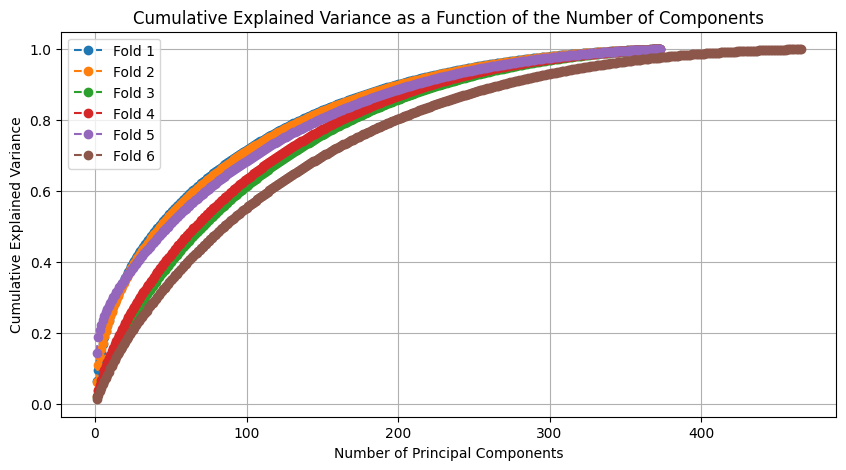

Done


In [13]:
MODALITY = Modality.CT
results = fit_PCA("dino_vitb8_4", n_components=None, plot_variance_ratio=True)

##### Saving top n components

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.05it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.07it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.05it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:27<00:00,  1.08it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


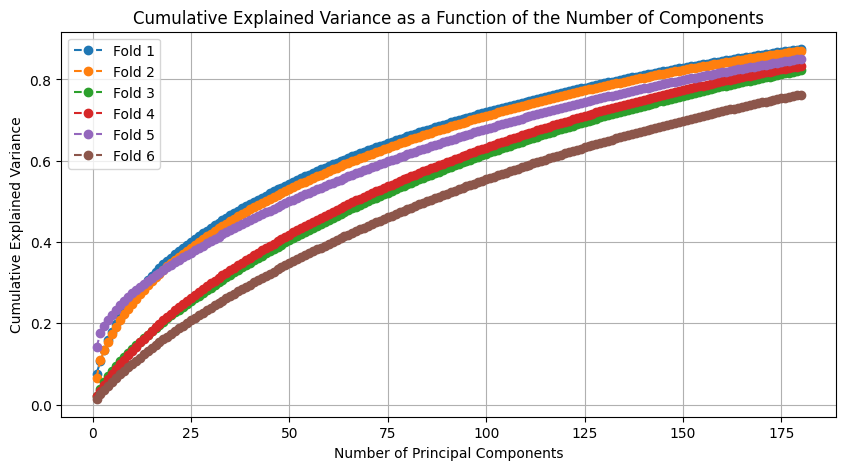

Done


In [14]:
MODALITY = Modality.CT
results = fit_PCA("dino_vitb8_4", n_components=180, plot_variance_ratio=True, save_PCA_factors=True)

#### Exctracting features ViTb8 - BOTH CT and PET

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.04it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.03it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.03it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.03it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.03it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.04it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


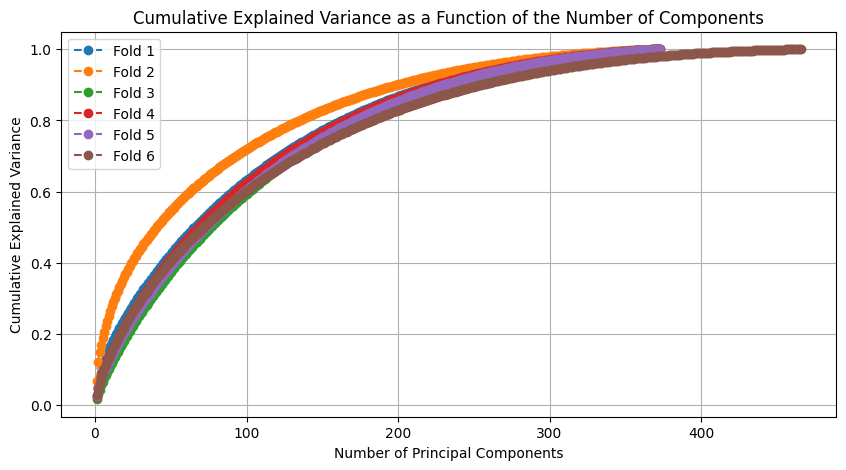

Done


In [15]:
MODALITY = Modality.BOTH
results = fit_PCA("dino_vitb8_6", n_components=None, plot_variance_ratio=True)

##### Saving top n components

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.02it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.01it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.05it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.02it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.05it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


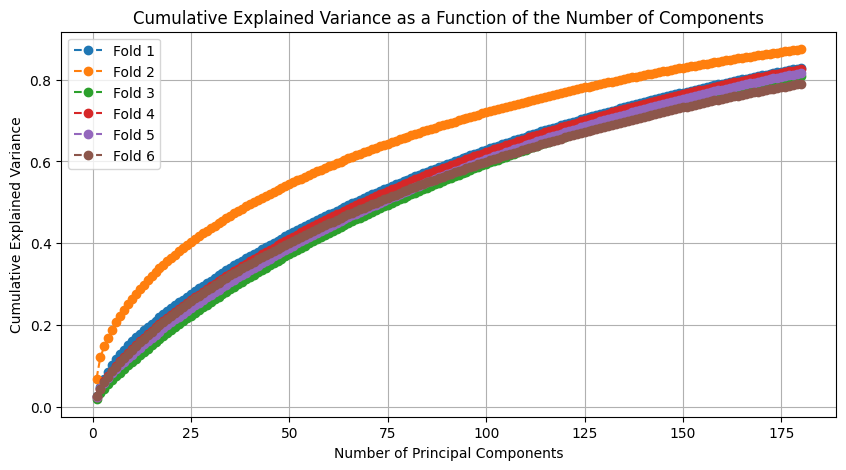

Done


In [16]:
MODALITY = Modality.BOTH
results = fit_PCA("dino_vitb8_6", n_components=180, plot_variance_ratio=True, save_PCA_factors=True)

#### Exctracting features ViTb8 - MERGED CT and PET

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.03it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.04it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.04it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.03it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.04it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


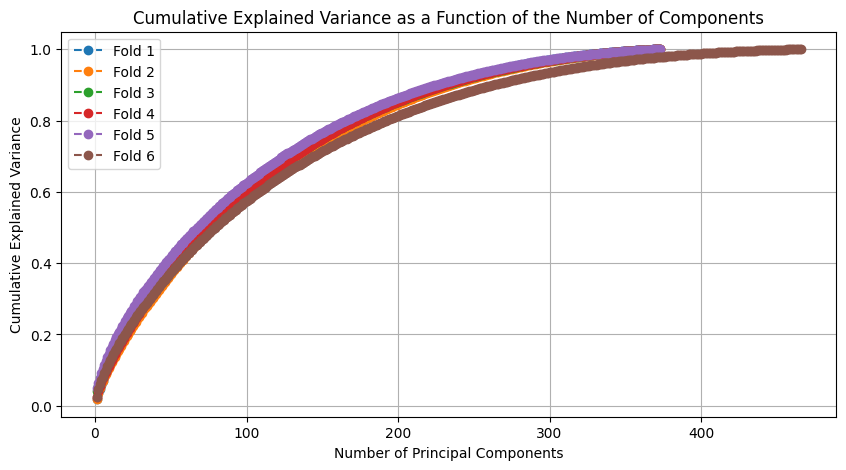

Done


In [17]:
MODALITY = Modality.MERGED
results = fit_PCA("dino_vitb8_5", n_components=None, plot_variance_ratio=True)

##### Saving top n components

Fold: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.05it/s]


Fold: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.02it/s]


Fold: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.04it/s]


Fold: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.04it/s]


Fold: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.04it/s]


Fold: all


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.04it/s]


Finalizing features extraction ...
Features extracted
Fitting PCA ...


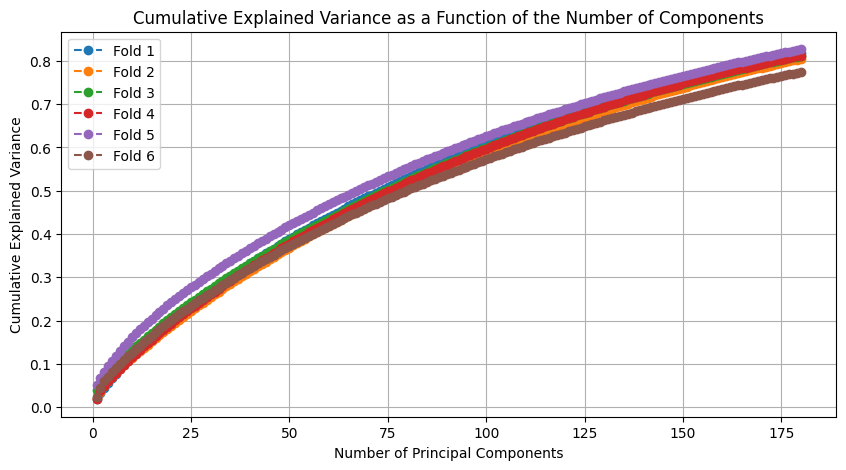

Done


In [18]:
MODALITY = Modality.MERGED
results = fit_PCA("dino_vitb8_5", n_components=180, plot_variance_ratio=True, save_PCA_factors=True)

### Evaluating with PCA on the test set

In [19]:
def model_evaluation_PCA(model_name:str, version:Optional[str]=None):
    """
    Evaluates Hecktor model on the test set.
    """
    res={}
    def _setup(fold:Union[int, Literal["all"]]=1):
        # DataModule setup:
        dm = HECKTOR_DataModule(
            fold=fold,
            data_path=DATA_PATH,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            selected_train_transforms=SELECTED_TRAIN_TRANSFORMS,
            modality=MODALITY
        )
        
        if version is None:
            ckpt_path = CHECKPOINTS_PATH+"PCA_"+model_name+f"_{fold}"+".ckpt"
        else:
            ckpt_path = CHECKPOINTS_PATH+"PCA_"+model_name+f"_{fold}"+f"-{version}"+".ckpt"
        # Model setup:
        model = PCA_HECKTOR_Model.load_from_checkpoint(ckpt_path)
        # Trainer setup:
        torch.set_float32_matmul_precision('medium')
        trainer = pl.Trainer(accelerator="gpu", devices=1, precision=32, logger=False)
        
        return dm, model, trainer

    # Evaluating models trained on 5CV training sets:
    for fold in range(1, 6):
        dm, model, trainer = _setup(fold=fold)
        model.eval()
        res[f"val_fold_{fold}"] = trainer.validate(model, dm)
        res[f"test_fold_{fold}"] = trainer.test(model, dm)
        
    if version == None:
        # Evaluating model trained on the whole training set:
        fold="all"
        dm, model, trainer = _setup(fold=fold)
        model.eval()
        res["test_all"] = trainer.test(model, dm)
        
    return res


def compute_results(raw_results:Dict[str, list]):
    val_c_index = []
    test_c_index = []
    test_loss = []
    folds = []

    for fold in range(1,6):
        curr_val_c_index = round(raw_results[f"val_fold_{fold}"][0]["val_C-index"],3)
        curr_test_c_index = round(raw_results[f"test_fold_{fold}"][0]["test_C-index"],3)
        curr_test_loss = round(raw_results[f"test_fold_{fold}"][0]["test_loss"],3)
        val_c_index.append(curr_val_c_index)
        test_c_index.append(curr_test_c_index)
        test_loss.append(curr_test_loss)
        folds.append(f"Fold {fold}")

    # Results of model trained on the whole train set:
    if "test_all" in raw_results.keys():
        val_c_index.append("NA")
        test_c_index.append(round(raw_results["test_all"][0]["test_C-index"],3))
        test_loss.append(round(raw_results["test_all"][0]["test_loss"],3))
        folds.append("All train set")

    df = pd.DataFrame({"Fold": folds, "Test C-index": test_c_index, "Val C-index": val_c_index, "Test loss": test_loss})
    
    table = PrettyTable()
    table.field_names = df.columns.tolist()

    for row in df.itertuples(index=False):
        table.add_row(row)

    for field in df.columns:
        table.align[field] = 'l'
    
    return table

### DINO_ViTs8 - only CT

##### Version 0

In [ ]:
# version 0
MODALITY = Modality.CT
res = model_evaluation_PCA("dino_vits8_1_1")

In [43]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.537,0.556,2.535
Fold 2,0.421,0.478,2.54
Fold 3,0.464,0.505,2.585
Fold 4,0.547,0.569,2.533
Fold 5,0.449,0.545,2.534
All train set,0.455,NA,2.537


##### Version 1

In [ ]:
# version 1
MODALITY = Modality.CT
res = model_evaluation_PCA("dino_vits8_1_1", "v1")

In [45]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.529,0.522,2.536
Fold 2,0.422,0.479,2.54
Fold 3,0.464,0.504,2.586
Fold 4,0.548,0.569,2.533
Fold 5,0.458,0.551,2.534


##### Version 2

In [ ]:
# version 2
MODALITY = Modality.CT
res = model_evaluation_PCA("dino_vits8_1_1", "v2")

In [47]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.532,0.514,2.536
Fold 2,0.422,0.468,2.54
Fold 3,0.464,0.515,2.589
Fold 4,0.546,0.573,2.532
Fold 5,0.473,0.521,2.532


### DINO_ViTs8 - Both CT and PET

##### Version 0

In [ ]:
# version 0
MODALITY = Modality.BOTH
res = model_evaluation_PCA("dino_vits8_3_3")

In [49]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.587,0.726,2.531
Fold 2,0.43,0.387,2.534
Fold 3,0.579,0.681,2.532
Fold 4,0.565,0.586,2.532
Fold 5,0.579,0.656,2.512
All train set,0.584,NA,2.525


##### Version 1

In [ ]:
# version 1
MODALITY = Modality.BOTH
res = model_evaluation_PCA("dino_vits8_3_3", "v1")

In [51]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.587,0.725,2.531
Fold 2,0.43,0.397,2.534
Fold 3,0.577,0.658,2.535
Fold 4,0.565,0.586,2.533
Fold 5,0.577,0.656,2.517


##### Version 2

In [ ]:
# version 2
MODALITY = Modality.BOTH
res = model_evaluation_PCA("dino_vits8_3_3", "v2")

In [53]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.586,0.732,2.534
Fold 2,0.427,0.379,2.535
Fold 3,0.577,0.658,2.535
Fold 4,0.564,0.585,2.53
Fold 5,0.577,0.656,2.517


### DINO_ViTs8 - CT merged with PET

##### Version 0

In [ ]:
# version 0
MODALITY = Modality.MERGED
res = model_evaluation_PCA("dino_vits8_2_2")

In [37]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.557,0.668,2.534
Fold 2,0.561,0.589,2.535
Fold 3,0.557,0.664,2.54
Fold 4,0.559,0.641,2.537
Fold 5,0.558,0.679,2.54
All train set,0.506,NA,2.537


##### Version 1

In [ ]:
# version 1
MODALITY = Modality.MERGED
res = model_evaluation_PCA("dino_vits8_2_2", "v1")

In [39]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.556,0.668,2.534
Fold 2,0.563,0.589,2.531
Fold 3,0.558,0.664,2.54
Fold 4,0.571,0.623,2.536
Fold 5,0.558,0.68,2.538


##### Version 2

In [ ]:
# version 2
MODALITY = Modality.MERGED
res = model_evaluation_PCA("dino_vits8_2_2", "v2")

In [41]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.556,0.665,2.534
Fold 2,0.563,0.589,2.53
Fold 3,0.557,0.664,2.539
Fold 4,0.572,0.619,2.536
Fold 5,0.558,0.68,2.539


### DINO_ViTb8 - only CT

##### Version 0

In [ ]:
# version 0
MODALITY = Modality.CT
res = model_evaluation_PCA("dino_vitb8_4_4")

In [22]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.503,0.539,2.596
Fold 2,0.515,0.454,2.653
Fold 3,0.555,0.426,2.537
Fold 4,0.467,0.46,2.538
Fold 5,0.567,0.521,2.534
All train set,0.563,NA,2.535


##### Version 1

In [ ]:
MODALITY = Modality.CT
res = model_evaluation_PCA("dino_vitb8_4_4", "v1")

In [24]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.502,0.544,2.597
Fold 2,0.516,0.454,2.652
Fold 3,0.507,0.486,2.538
Fold 4,0.446,0.458,2.539
Fold 5,0.567,0.523,2.534


##### Version 2

In [ ]:
# version 2
MODALITY = Modality.CT
res = model_evaluation_PCA("dino_vitb8_4_4", "v2")

In [26]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.512,0.534,2.596
Fold 2,0.515,0.463,2.633
Fold 3,0.551,0.438,2.537
Fold 4,0.467,0.464,2.538
Fold 5,0.569,0.516,2.535


### DINO_ViTb8 - Both CT and PET

##### Version 0

In [ ]:
MODALITY = Modality.BOTH
res = model_evaluation_PCA("dino_vitb8_6_6")

In [28]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.588,0.66,2.523
Fold 2,0.574,0.59,2.682
Fold 3,0.572,0.644,2.529
Fold 4,0.462,0.586,2.539
Fold 5,0.578,0.672,2.519
All train set,0.558,NA,2.556


##### Version 1

In [ ]:
MODALITY = Modality.BOTH
res = model_evaluation_PCA("dino_vitb8_6_6", "v1")

In [30]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.588,0.66,2.523
Fold 2,0.569,0.59,2.754
Fold 3,0.572,0.645,2.529
Fold 4,0.559,0.579,2.536
Fold 5,0.578,0.672,2.519


##### Version 2

In [ ]:
MODALITY = Modality.BOTH
res = model_evaluation_PCA("dino_vitb8_6_6", "v2")

In [32]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.588,0.66,2.523
Fold 2,0.575,0.594,2.68
Fold 3,0.572,0.646,2.529
Fold 4,0.559,0.579,2.537
Fold 5,0.579,0.673,2.519


### DINO_ViTb8 - CT merged with PET

##### Version 0

In [ ]:
MODALITY = Modality.MERGED
res = model_evaluation_PCA("dino_vitb8_5_5")

In [34]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.563,0.664,2.535
Fold 2,0.527,0.541,2.536
Fold 3,0.556,0.662,2.538
Fold 4,0.561,0.618,2.532
Fold 5,0.56,0.634,2.549
All train set,0.559,NA,2.545


##### Version 1

In [ ]:
MODALITY = Modality.MERGED
res = model_evaluation_PCA("dino_vitb8_5_5", "v1")

In [36]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.563,0.662,2.535
Fold 2,0.528,0.54,2.536
Fold 3,0.554,0.66,2.54
Fold 4,0.561,0.618,2.532
Fold 5,0.56,0.634,2.55


##### Version 2

In [ ]:
MODALITY = Modality.MERGED
res = model_evaluation_PCA("dino_vitb8_5_5", "v2")

In [38]:
compute_results(res)

Fold,Test C-index,Val C-index,Test loss
Fold 1,0.563,0.662,2.535
Fold 2,0.525,0.529,2.536
Fold 3,0.555,0.661,2.543
Fold 4,0.561,0.619,2.532
Fold 5,0.56,0.634,2.548
